In [1]:
import re
import urllib.request
import tqdm
import time
import os

#------------------------------------------------------------------------
def get_date_input(prompt):
    while True:
        date_input = input(prompt)
        # Validate date format
        if re.match(r'^\d{4}-\d{2}-\d{2}$', date_input):
            return date_input
        else:
            print("Invalid date format. Please use yyyy-mm-dd format.")

#------------------------------------------------------------------------
def get_save_directory_input(default_directory):
    while True:
        save_directory = input(f"Enter the directory to save the data (press Enter to use default directory {default_directory}): ")
        if not save_directory:
            return default_directory
        # Validate directory exists
        elif os.path.isdir(save_directory):
            return save_directory
        else:
            print("Directory does not exist. Please enter a valid directory.")

#------------------------------------------------------------------------
def build_url1(station_code, start_date, end_date):
    base_url = 'https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no='
    query_params = '&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=' \
                   'LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1' \
                   '&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no' \
                   '&column_name=station_nm&range_selection=date_range&begin_date=' + start_date + '&end_date=' + end_date + \
                   '&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection'

    return base_url + station_code + query_params

#------------------------------------------------------------------------
# Retrieve and save data from a URL, and return the filename
def retrieve_and_save_data(url, filename):
    print("\nDownloading data from:", url , '\n')
    response = urllib.request.urlopen(url)
    total_size = int(response.headers.get('content-length', 0))
    downloaded = 0
    chunk_size = 1024
    start_time = time.time()  # Record start time
    with open(filename, 'wb') as file:
        while True:
            chunk = response.read(chunk_size)
            if not chunk:
                break
            file.write(chunk)
            downloaded += len(chunk)
            if total_size > 0:
                progress = downloaded / total_size * 100
            else:
                # Assume 1.2 seconds download time if total_size is zero
                elapsed_time = time.time() - start_time
                progress = min(100, elapsed_time / 1.2 * 100)
            print(f"Estimated downloading progress: {progress:.1f}%\r", end='')
    print("\nData saved to:", filename)
    return filename

#--------------------------------------------------------------------------
#                          Define the inputs
#--------------------------------------------------------------------------
print(" ------------------------------------------",
        "\n Please provide the following information:",
        "\n ------------------------------------------")
# activate code below ands suppress followig 3 lines
#station_code = input('- USGS station ID: ')
#start_date = get_date_input('- Start Date (yyyy-mm-dd): ')
#end_date = get_date_input('- End Date (yyyy-mm-dd): ')
# suppress these for interactive
station_code = '08073600'
start_date = '1936-01-01'
end_date = '2024-02-01'

#--------- !!! Define the directory where the data will be saved !!! -----------
default_directory = r"C:\Users\mbaraka\OneDrive - Texas Tech University\Thesis file"  # To be defined!

#save_directory = get_save_directory_input(default_directory)
save_directory = './' # suppress and actiovate above for interactive

#--------------------------------------------------------------------------
#        Define the base URLs for data retrieval from Website 1
#--------------------------------------------------------------------------
url1 = build_url1(station_code, start_date, end_date)

# Retrieve and save data from Website 1
filename1 = retrieve_and_save_data(url1, os.path.join(save_directory, f'USGS_Data_for_{station_code}.txt'))


 ------------------------------------------ 
 Please provide the following information: 
 ------------------------------------------




Estimated downloading progress: 100.0%
Data saved to: ./USGS_Data_for_08073600.txt


Data from Website 1:
           agency_cd   site_no  flow_rate flag
datetime                                      
1971-09-01      USGS  08073600      170.0    A
1971-09-02      USGS  08073600      160.0    A
1971-09-03      USGS  08073600      150.0    A
1971-09-04      USGS  08073600      220.0    A
1971-09-05      USGS  08073600      200.0    A


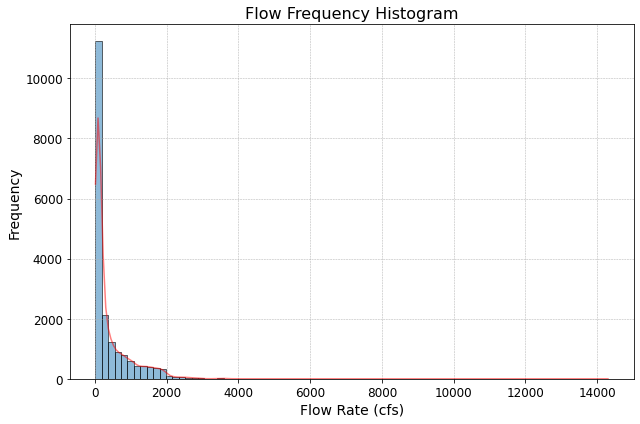

--------- Statistics: ----------

-  Sample Size: 19147
-  Median: 130.00
-  Mean: 411.33
-  Standard Deviation: 628.99
-  Variance: 395622.35
-  Minimum: 16.00
-  Maximum: 14300.00
-  First Quartile: 74.00
-  Third Quartile: 510.00
-  Interquartile Range: 436.00
-  Number of Outliers: 2089



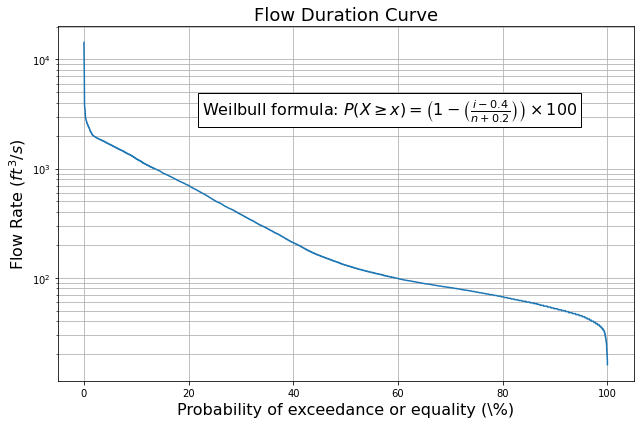

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

#------------------------------------------------------------------------
# Process data from a text file and return a cleaned DataFrame for Website 1
def process_website1_data(filename, station_code):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("USGS"):
                parts = line.split("\t")
                agency_cd, site_no, datetime, flow_rate, flag = parts[:5]
                data.append([agency_cd, site_no, datetime, flow_rate, flag])

    df = pd.DataFrame(data, columns=['agency_cd', 'site_no', 'datetime', 'flow_rate', 'flag'])
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df['flow_rate'] = pd.to_numeric(df['flow_rate'], errors='coerce')
    df.set_index('datetime', inplace=True)
    
    # Filter and keep rows where 'flag' is not equal to "P"
    df = df[df['flag'] != 'P\n']
    
    df.dropna(subset=['flow_rate'], inplace=True)

    csv_filename1 = os.path.join(save_directory, f'{station_code}_flow_data.csv')
    df.to_csv(csv_filename1)
    
    return df

#------------------------------------------------------------------------
def analyze_data(df):
    """
    Performs statistical analysis on the flow rate data and saves the results to a CSV file.

    Parameters:
    df (DataFrame): DataFrame containing flow rate data.
    """
    sample_size = len(df)
    median = df['flow_rate'].median()
    mean = df['flow_rate'].mean()
    std = df['flow_rate'].std()
    variance = df['flow_rate'].var()
    minimum = df['flow_rate'].min()
    maximum = df['flow_rate'].max()
    first_quartile = df['flow_rate'].quantile(0.25)
    third_quartile = df['flow_rate'].quantile(0.75)
    interquartile_range = third_quartile - first_quartile
    
    # Calculate number of outliers
    outliers = df[(df['flow_rate'] < first_quartile - 1.5 * interquartile_range) | (df['flow_rate'] > third_quartile + 1.5 * interquartile_range)]
    num_outliers = len(outliers)

    # Display statistics
    print("--------- Statistics: ----------\n")
    print(f"-  Sample Size: {sample_size}")
    print(f"-  Median: {median:.2f}")
    print(f"-  Mean: {mean:.2f}")
    print(f"-  Standard Deviation: {std:.2f}")
    print(f"-  Variance: {variance:.2f}")
    print(f"-  Minimum: {minimum:.2f}")
    print(f"-  Maximum: {maximum:.2f}")
    print(f"-  First Quartile: {first_quartile:.2f}")
    print(f"-  Third Quartile: {third_quartile:.2f}")
    print(f"-  Interquartile Range: {interquartile_range:.2f}")
    print(f"-  Number of Outliers: {num_outliers}")
    print()
    
    # Create DataFrame for statistics
    statistics_df = pd.DataFrame({
        'Statistic': ['Sample Size', 'Median', 'Mean', 'Standard Deviation', 'Variance', 'Minimum', 'Maximum', 'First Quartile', 'Third Quartile', 'Interquartile Range', 'Number of Outliers'],
        'Value': [sample_size, median, mean, std, variance, minimum, maximum, first_quartile, third_quartile, interquartile_range, num_outliers]
    })

    # Save statistics to CSV file
    statistics_filename = os.path.join(save_directory, f'{station_code}_statistics.csv')
    statistics_df.to_csv(statistics_filename, index=False)

#------------------------------------------------------------------------
def plot_flow_frequency_histogram(df):
    """
    Plots the flow frequency histogram with a fitted KDE based on the flow rates in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing flow rate data.
    """
    plt.figure(figsize=(9, 6))
    ax = sns.histplot(df['flow_rate'], bins=80, kde=True, edgecolor='black')
    kde_color = 'red'
    kde_alpha = 0.5
    ax.get_lines()[0].set_color(kde_color)
    ax.get_lines()[0].set_alpha(kde_alpha)
    ax.set_title('Flow Frequency Histogram', fontsize=16)
    ax.set_xlabel('Flow Rate (cfs)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Ensure tight layout to prevent cropping of labels
    plt.savefig(os.path.join(save_directory, f'{station_code}_flow_frequency_histogram.png'))
    plt.show()

#------------------------------------------------------------------------
def plot_flow_duration_curve(df):
    """
    Plots the flow duration curve (FDC).

    Parameters:
    df (DataFrame): DataFrame containing flow rate data.
    """
    # Sort the flow rates in descending order
    df_sorted = df.sort_values('flow_rate', ascending=False)

    # Compute the cumulative probability
    # The generalized form proposed by Gringorten (1963) a = 0.4
    df_sorted['cumulative_probability'] = ((np.arange(len(df_sorted))+0.6) / (len(df_sorted)+1.2)) * 100

    # Plot the flow duration curve
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.semilogy(df_sorted['cumulative_probability'], df_sorted['flow_rate'])
    ax.set_title('Flow Duration Curve', fontsize=18)
    ax.set_xlabel('Probability of exceedance or equality (\%)', fontsize=16)
    ax.set_ylabel('Flow Rate ($ft^3/s$)', fontsize=16)
    ax.grid(which='both')

    # Add legend with the Weibull formula
    equation = r'$P(X \geq x) = \left(1 - \left(\frac{i-0.4}{n+0.2}\right)\right) \times 100$'
    #ax.legend(['Flow Duration Curve', f'Weibull Fit: {equation}'], bbox_to_anchor=(0.35, .95), loc='upper left', fontsize=16)

    # Add text box with the Weibull formula
    ax.text(0.25, 0.8, f'Weilbull formula: {equation}', transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

    plt.tight_layout()  # Ensure tight layout to prevent cropping of labels
    
    plt.savefig(os.path.join(save_directory, f'{station_code}_fdc.png'))
    plt.show()

#--------------------------------------------------------------------------
#      Preprocess the Retrieved Data and Display the Head Part of it 
#--------------------------------------------------------------------------
df1 = process_website1_data(filename1, station_code)

# Display the first few rows of data from Website 1
print("Data from Website 1:")
print(df1.head())

#--------------------------------------------------------------------------
#                                 Plotting 
#--------------------------------------------------------------------------
# Plot the flow frequency histogram with a fitted KDE
plot_flow_frequency_histogram(df1)

# Statistical analysis
analyze_data(df1)

# Flow duration curve
plot_flow_duration_curve(df1)


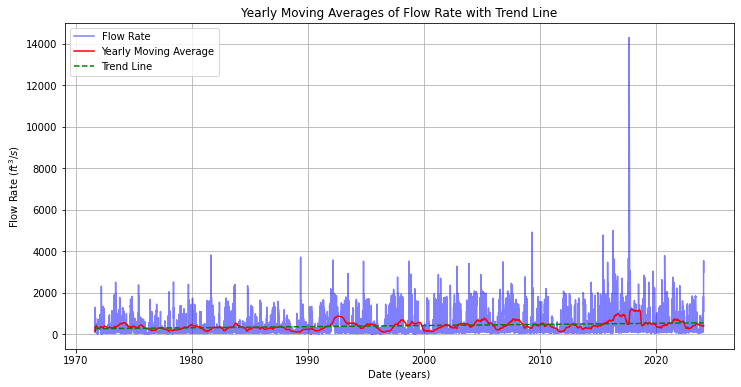

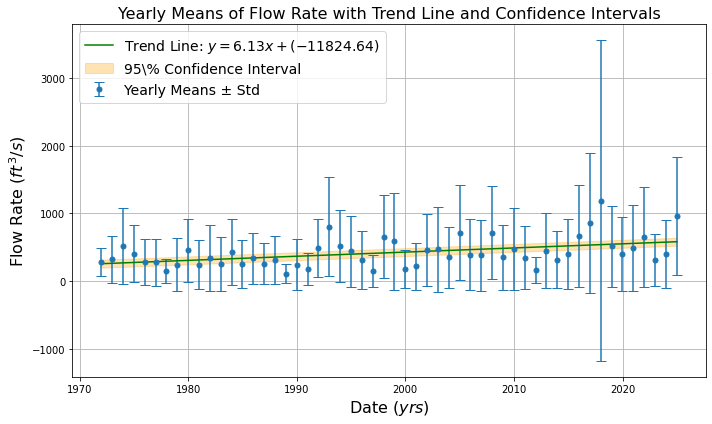

datetime
1971-12-31     283.254098
1972-12-31     323.412568
1973-12-31     517.183562
1974-12-31     401.427397
1975-12-31     279.704110
1976-12-31     278.019126
1977-12-31     143.989041
1978-12-31     241.339726
1979-12-31     457.534247
1980-12-31     241.196721
1981-12-31     339.372603
1982-12-31     254.605479
1983-12-31     423.901370
1984-12-31     252.248634
1985-12-31     334.166849
1986-12-31     257.818630
1987-12-31     305.469315
1988-12-31     110.948087
1989-12-31     241.512329
1990-12-31     176.945205
1991-12-31     489.257534
1992-12-31     805.131148
1993-12-31     516.213699
1994-12-31     438.810959
1995-12-31     311.334247
1996-12-31     153.101093
1997-12-31     657.758904
1998-12-31     588.884932
1999-12-31     171.638356
2000-12-31     220.625683
2001-12-31     457.016438
2002-12-31     468.321644
2003-12-31     348.976438
2004-12-31     717.306831
2005-12-31     386.320000
2006-12-31     379.950137
2007-12-31     717.768493
2008-12-31     350.637978
200

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.linear_model import LinearRegression

#------------------------------------------------------------------------
def plot_yearly_moving_average(df):
    """
    Plots the yearly moving averages of flow rate data along with a trend line.

    Parameters:
    df (DataFrame): DataFrame containing flow rate data.
    """
    # Compute yearly moving averages
    yearly_ma = df['flow_rate'].rolling(window=365, min_periods=1).mean()
    
    # Plot data and moving averages
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['flow_rate'], label='Flow Rate', color='blue', alpha=0.5)
    plt.plot(yearly_ma.index, yearly_ma, label='Yearly Moving Average', color='red')
    
    # Fit a trend line
    trend_coef = np.polyfit(df.index.to_julian_date(), df['flow_rate'], 1)
    trend_line = np.poly1d(trend_coef)
    plt.plot(df.index, trend_line(df.index.to_julian_date()), label='Trend Line', linestyle='--', color='green')

    plt.title('Yearly Moving Averages of Flow Rate with Trend Line')
    plt.xlabel('Date (years)')
    plt.ylabel('Flow Rate ($ft^3/s$)')
    plt.legend()
    plt.grid(True)
    plt.show()

#------------------------------------------------------------------------
def plot_yearly_means_with_trend(df):
    """
    Plots the yearly means of flow rate data with error bars (std) and a trend line with shaded confidence intervals.
    NaN values in flow rate are replaced by the mean of all non-NaN flow rates,
    and NaN values in standard deviation are replaced by the mean of all non-NaN standard deviations.

    Parameters:
    df (DataFrame): DataFrame containing flow rate data.
    """
    # Compute yearly means and standard deviations
    yearly_means = df['flow_rate'].resample('Y').mean()
    yearly_std = df['flow_rate'].resample('Y').std()

    # Replace NaN values in flow rate with the mean of all non-NaN flow rates
    yearly_means.fillna(yearly_means.mean(), inplace=True)
    
    # Replace NaN values in std with the mean of all non-NaN std
    yearly_std.fillna(yearly_std.mean(), inplace=True)
    
    # Prepare data for linear regression
    X = yearly_means.index.year.values.reshape(-1, 1)
    y = yearly_means.values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Compute trend line values
    trend_values = model.predict(X)
    
    # Compute overall mean and standard deviation of yearly means
    overall_mean = yearly_means.mean()
    overall_std = yearly_means.std()
    
    # Compute t-value for a 95% confidence interval with n-1 degrees of freedom
    t_value = t.ppf(0.975, len(yearly_means) - 1)
    
    # Compute margin of error
    margin_of_error = t_value * overall_std / np.sqrt(len(yearly_means))
    
    # Compute upper and lower bounds of the confidence interval for the overall mean
    upper_bound = trend_values + margin_of_error
    lower_bound = trend_values - margin_of_error
    
    # Plot yearly means with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(yearly_means.index, yearly_means, yerr=yearly_std, fmt='o', markersize=5, capsize=5, label='Yearly Means ± Std')
    
    # Plot trend line
    plt.plot(yearly_means.index, trend_values, label=f'Trend Line: $y = {model.coef_[0]:.2f}x + ({model.intercept_:.2f})$', linestyle='-', color='green')
    
    # Shade confidence interval
    plt.fill_between(yearly_means.index, lower_bound, upper_bound, color='orange', alpha=0.3, label='95\% Confidence Interval')
    
    plt.title('Yearly Means of Flow Rate with Trend Line and Confidence Intervals', fontsize=16)
    plt.xlabel('Date $(yrs)$', fontsize=16)
    plt.ylabel('Flow Rate $(ft^3/s)$', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()  # Ensure tight layout to prevent cropping of labels
    plt.savefig(os.path.join(save_directory, f'{station_code}_yearly_mean.png'))
    plt.show()
    return yearly_means

#------------------------------------------------------------------------
#                         Moving average 
#------------------------------------------------------------------------
plot_yearly_moving_average(df1)
plot_yearly_means_with_trend(df1)


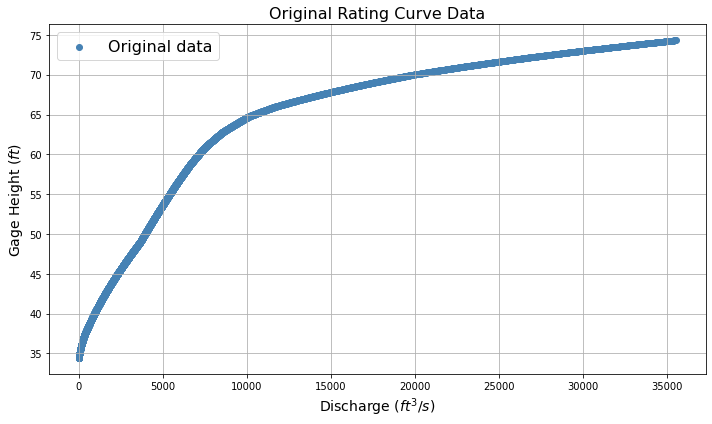

Fitting failed: Maximum number of function evaluations has been exceeded.
Fitting failed. Unable to plot the fitted curve.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import requests 

#------------------------------------------------------------------------
# Define the equation a * Q^b + c
def rating_equation(Q, a, b, c):
    return a * np.power(Q, b) + 1/c

#------------------------------------------------------------------------
# Retrieve rating curve data
def retrieve_rating_curve_data(station_code):
    url = f"https://waterdata.usgs.gov/nwisweb/get_ratings?file_type=exsa&site_no={station_code}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve data for station code {station_code}.")
    df = pd.read_csv(response.url, skiprows=29, delimiter="\t", names=["INDEP", "SHIFT", "DEP", "STOR"])
    df = df[["INDEP", "DEP"]]
    df.columns = ["Gage Height", "Discharge"]
    df["Gage Height"] = pd.to_numeric(df["Gage Height"], errors="coerce")
    df["Discharge"] = pd.to_numeric(df["Discharge"], errors="coerce")
    df = df.dropna()
    df = df.sort_values(by="Discharge")
    return df

#------------------------------------------------------------------------
# Plot the original rating curve data
def plot_original_data(df_rating):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_rating['Discharge'], df_rating['Gage Height'], label='Original data', color='steelblue')
    plt.xlabel('Discharge $(ft^3/s)$', fontsize=14)
    plt.ylabel('Gage Height $(ft)$', fontsize=14)
    plt.title('Original Rating Curve Data', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

#------------------------------------------------------------------------
# Objective function to minimize R-squared
def objective_function(params, df_rating, equation_func):
    predicted_gage_height = equation_func(df_rating['Discharge'], *params)
    ss_residuals = np.sum((df_rating['Gage Height'] - predicted_gage_height)**2)
    ss_total = np.sum((df_rating['Gage Height'] - np.mean(df_rating['Gage Height']))**2)
    
    # Check if ss_total is close to zero
    if ss_total < 1e-10:  # Adjust threshold as needed
        return -1e10      # Return a large negative value to discourage such solutions
    
    r_squared = 1 - (ss_residuals / ss_total)
    return -r_squared      # Minimize negative R-squared

#------------------------------------------------------------------------
# Fit the equation using minimization of residuals
def fit_rating_curve(df_rating):
    x0 = np.ones(3)  # Initial guess for parameters [a, b, c]
    res = minimize(objective_function, x0, args=(df_rating, rating_equation), method='Nelder-Mead')
    if res.success:
        # Calculate predicted gage heights
        predicted_gage_heights = rating_equation(df_rating['Discharge'], *res.x)
        
        # Calculate R-squared
        r_squared = r2_score(df_rating['Gage Height'], predicted_gage_heights)
        
        return res.x, r_squared
    else:
        print("Fitting failed:", res.message)  # Print out the error message
        return None, None

#------------------------------------------------------------------------
# Plot the fitting rating curve
def plot_fitted_curve(df_rating, params, r_squared):
    # Define colors for scatter and curve
    scatter_color = 'steelblue'
    curve_color = 'darkorange'

    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot original data as scatter points
    ax.scatter(df_rating['Discharge'], df_rating['Gage Height'], label='Original data', color=scatter_color, alpha=0.7)

    # Generate fitted curve
    Q_fit = np.linspace(df_rating['Discharge'].min(), df_rating['Discharge'].max(), 100)
    fitted_curve = rating_equation(Q_fit, *params)
    
    # Plot fitted curve
    ax.plot(Q_fit, fitted_curve, label=f'Fitted curve: $H(Q) = a \cdot Q^b + \\frac{{1}}{{c}}$', color=curve_color, linewidth=3)

    # Add equation and R-squared value as text box
    equation_text = f"$H(Q) = {params[0]:.3f} \cdot Q^{{{params[1]:.3f}}} + \\frac{{1}}{{{params[2]:.3f}}}$"
    r_squared_text = f"$R^2 = {r_squared:.4f}$"
    text_box_content = f"{equation_text}\n\n{r_squared_text}"
    ax.text(0.55, 0.35, text_box_content, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    # Set labels and title
    ax.set_xlabel('Discharge $(ft^3/s)$', fontsize=14)
    ax.set_ylabel('Gage Height $(ft)$', fontsize=14)
    ax.set_title('Fitted Rating Curve', fontsize=16)
    
    # Add grid
    ax.grid(True)

    # Add legend
    ax.legend(fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Save plot as PNG file
    plt.savefig(f'{station_code}fitted_rating_curve.png')

    # Show plot
    plt.show()

#------------------------------------------------------------------------
#Main function to operate the script
def main(station_code):
    # Step 1: Retrieve and clean data
    df_rating = retrieve_rating_curve_data(station_code)
    
    # Step 2: Plot original data
    plot_original_data(df_rating)
    
    # Step 3: Fit the curve
    params, r_squared = fit_rating_curve(df_rating)
    
    # Step 4: Plot the fitted curve
    if params is not None:
        plot_fitted_curve(df_rating, params, r_squared)
    else:
        print("Fitting failed. Unable to plot the fitted curve.")

#--------------------------------------------------------------------------
#           Call the main function by the station code
#--------------------------------------------------------------------------
main(station_code)
